In [2]:
!python -m pip install lmfit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint


Matplotlib is building the font cache; this may take a moment.


In [5]:
# Import data
df = pd.read_csv('patient.csv')
#filling missing values with 0
df = df.fillna(0)
df.head()

,Timestamp,BG,Insulin Bolus,Noise,Eating
0,07:30,65,10,N,16.6
1,07:45,83,0,N,0.0
2,08:00,103,0,N,0.0
3,08:15,113,0,N,0.0
4,08:30,114,0,N,0.0


In [6]:
#Make Timestamp into a time series T_values list
from datetime import datetime

# Step 2: Convert the "Timestamp" column to datetime objects
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Step 3: Calculate the time differences and convert to seconds starting at 0
start_time = df['Timestamp'].iloc[0]
df['TimeInMinutes'] = (df['Timestamp'] - start_time).dt.total_seconds() / 60

# Convert the "TimeInMinutes" column to a list
time_values = df['TimeInMinutes'].tolist()

print(len(time_values))


15


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22912\3084478459.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


In [7]:
#Make BG into a list
BG_values = df['BG'].tolist()
#Make Insulin into a list
Insulin_values = df['Insulin Bolus'].tolist()
#Make Eating into a list
Eating_values = df['Eating'].tolist()

#Make Noise into a list that 'N' is replace by 1; 'Y' is replace by 1/2 and 'P' is replace by 0
Noise_values = df['Noise'].tolist()
Noise_values = [0.9 if x=='N' else x for x in Noise_values]
Noise_values = [1 if x=='Y' else x for x in Noise_values]
Noise_values = [0.9 if x=='P' else x for x in Noise_values]

time_values_cop = time_values.copy()
BG_values_cop = BG_values.copy()

print(len(BG_values_cop))
print(len(Eating_values))


15
15


In [8]:
time_values_cut = time_values
BG_values_cut = BG_values
Insulin_values_cut = Insulin_values
Eating_values_cut = Eating_values
Noise_values_cut = Noise_values


In [9]:
def softplus(x):
    return np.log(1 + np.exp(x))

def relu(x):
    return np.maximum(0, x)

In [10]:
def f(y, t, paras):
    """
    Your system of differential equations
    """

    G1 = y[0]
    G2 = y[1]
    I = y[2]

    try:
        alpha = paras['alpha'].value
        beta1 = paras['beta1'].value
        beta2 = paras['beta2'].value
        I_basal = paras['I_basal'].value
        gamma = paras['gamma'].value
        delta = paras['delta'].value
        I_max = paras['I_max'].value

    except KeyError:
        alpha, beta1, beta2, I_basal, gamma, delta, I_max = paras
    # the model equations
    eating_values = np.interp(t, time_values_cut, Eating_values_cut)
    dG1 = -alpha*G1 + eating_values
    dG2 = alpha*G1 - (beta1 + beta2 * (I+I_basal)) *G2
    # Find the corresponding insulin value for the current time point
    insulin_value = np.interp(t, time_values_cut, Insulin_values_cut)
    dI = gamma * softplus(G2 - 180) - delta * I + insulin_value
    return [dG1, dG2, dI]


def g(t, x0, paras):
    # Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    x = odeint(f, x0, t, args=(paras,))
    return x

def residual(paras, t, data):
    # Compute the residual between actual data and fitted data
    x0 = paras['G10'].value, paras['G20'].value, paras['I0'].value
    model = g(t, x0, paras)

    # Extract the second column of the model (G2)
    x2_model = model[:, 1] 

    # Calculate the weighted residual
    Noise_values_array = np.array(Noise_values_cut)
    weighted_residual = Noise_values_array * (x2_model - data)
    return weighted_residual.ravel()




In [11]:
# initial conditions
G10 = Eating_values_cut[0]
G20 = BG_values_cut[0]
I0 = Insulin_values_cut[0]
y0 = [G10, G20, I0]


# set parameters including bounds; you can also fix parameters (use vary=False)
# I fixed the initial concentrations, you could also set them as variables if you like (just remove the vary=False in the code below).
params = Parameters()
params.add('G10', value=G10, vary = False)
params.add('G20', value=G20, vary=False)
params.add('I0', value=I0, min = 0, vary = False)
params.add('alpha', value=0.5, min=0.001, max = 1)
params.add('beta1', value=0.03, min=0.0001)
params.add('beta2', value=0.02, min = 0.0001)
params.add('I_basal', value=0.3, min=0.05, max = 20)
params.add('gamma', value=0.2, min=0.0001, max  = 2)
params.add('delta', value=0.3, min=0.0001)
params.add('I_max', value=20, min = 5)

In [12]:
# fit model
result = minimize(residual, params, args=(time_values_cut, BG_values_cut), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(np.linspace(0., 500., 200), y0, result.params)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 240
    # data points      = 15
    # variables        = 7
    chi-square         = 1414.94015
    reduced chi-square = 176.867519
    Akaike info crit   = 82.2018847
    Bayesian info crit = 87.1582361
##  Warning: uncertainties could not be estimated:
    I_max:    at initial value
[[Variables]]
    G10:      16.6 (fixed)
    G20:      65 (fixed)
    I0:       10 (fixed)
    alpha:    0.01945486 (init = 0.5)
    beta1:    0.00380727 (init = 0.03)
    beta2:    3.0691e-04 (init = 0.02)
    I_basal:  1.39604321 (init = 0.3)
    gamma:    0.12758893 (init = 0.2)
    delta:    0.07742231 (init = 0.3)
    I_max:    20.0000000 (init = 20)


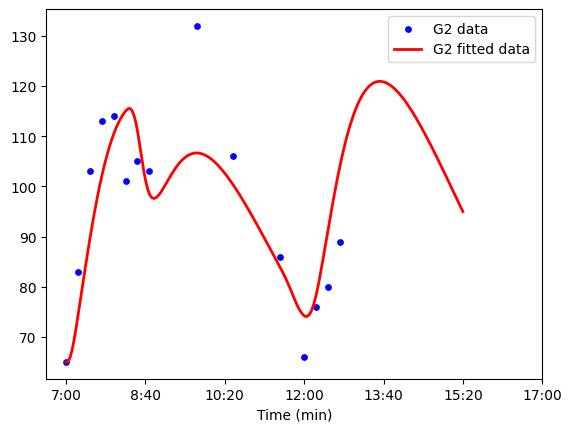

[65, 83, 103, 113, 114, 101, 105, 103, 132, 106, 86, 66, 76, 80, 89]


In [39]:
# plot fitted data
plt.figure()
plt.scatter(time_values_cut, BG_values_cut, marker='o', color='blue', label='G2 data', s=15)

#plt.plot(np.linspace(0., 700., 1000), data_fitted[:, 0], '-', linewidth=2, color='blue', label='G1 fitted data')
plt.plot(np.linspace(0., 500., 200), data_fitted[:, 1], '-', linewidth=2, color='red', label='G2 fitted data')
#plt.plot(np.linspace(0., 9., 100), data_fitted[:, 2], '-', linewidth=2, color='green', label='I fitted data')

# Define the time points corresponding to your data
time_points = np.arange(0, 2*60+30 + len(x), 100)

# Set the x-axis ticks and labels using the time_points
plt.xticks(time_points, [f"{t//60 + 7}:{t%60:02}" for t in time_points])

plt.xlabel('Time (min)')
plt.legend()

# display fitted statistics
report_fit(result)

plt.show()

print(BG_values_cut)

In [14]:
result.params

name,value,initial value,min,max,vary
G10,16.6000000,16.6,-inf,inf,False
G20,65.0000000,65,-inf,inf,False
I0,10.0000000,10,0.00000000,inf,False
alpha,0.01945486,0.5,1.0000e-03,1.00000000,True
beta1,0.00380727,0.03,1.0000e-04,inf,True
beta2,3.0691e-04,0.02,1.0000e-04,inf,True
I_basal,1.39604321,0.3,0.05000000,20.0000000,True
gamma,0.12758893,0.2,1.0000e-04,2.00000000,True
delta,0.07742231,0.3,1.0000e-04,inf,True
I_max,20.0000000,20,5.00000000,inf,True


In [23]:
def f1(y, t, paras):
    """
    Your system of differential equations
    """

    G1 = y[0]
    G2 = y[1]
    I = y[2]

    try:
        alpha = paras['alpha']
        beta1 = paras['beta1']
        beta2 = paras['beta2']
        I_basal = paras['I_basal']
        gamma = paras['gamma']
        delta = paras['delta']
        I_max = paras['I_max']

    except KeyError:
        alpha, beta1, beta2, I_basal, gamma, delta, I_max = paras
    # the model equations
    eating_values = np.interp(t, time_values, Eating_values)
    dG1 = -alpha*G1 + eating_values
    dG2 = alpha*G1 - (beta1 + beta2 * (I+I_basal)) *G2
    # Find the corresponding insulin value for the current time point
    insulin_value = np.interp(t, time_values, Insulin_values)

    dI = gamma * relu(G2 - 180) - delta * I + insulin_value
    return [dG1, dG2, dI]
    #dI = I_max * (reG2**2) / (gamma + reG2**2) - delta * I 
    #dI = I_max + gamma * relu(G2 -  92.5) - delta * I
    #dI = I_max * (G2**2) / (gamma + G2**2) - delta * I 
    #dI = I_max * G2 / (gamma + G2) - delta * I 
    #dI = gamma * G2 - delta * I


def g1(t, x0, paras):
    # Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    x = odeint(f1, x0, t, args=(paras,))
    return x

[[ 0.00000000e+00  7.90000000e+01  0.00000000e+00]
 [ 0.00000000e+00  7.50646278e+01  0.00000000e+00]
 [ 0.00000000e+00  7.13252945e+01  0.00000000e+00]
 [ 0.00000000e+00  6.77722356e+01  0.00000000e+00]
 [ 0.00000000e+00  6.43961716e+01  0.00000000e+00]
 [ 0.00000000e+00  6.11882853e+01  0.00000000e+00]
 [ 0.00000000e+00  5.81402009e+01  0.00000000e+00]
 [ 0.00000000e+00  5.52409259e+01  1.43855736e-01]
 [ 3.27381905e+01  5.22720904e+01  1.05694955e+00]
 [ 8.74170954e+01  5.15910655e+01  8.52430290e-02]
 [ 8.51365149e+01  5.14618101e+01  1.13216991e+00]
 [ 8.25788425e+01  5.07716436e+01  3.07181349e+00]
 [ 8.00980077e+01  4.96187200e+01  3.09459298e+00]
 [ 7.76917022e+01  4.90522230e+01  4.05732544e-01]
 [ 7.53576870e+01  4.88422023e+01  3.27223453e-02]
 [ 7.30937903e+01  4.86125381e+01  2.63905971e-03]
 [ 7.08979056e+01  4.83310909e+01  2.12839358e-04]
 [ 6.87679898e+01  4.79996070e+01  1.71662373e-05]
 [ 6.67020608e+01  4.76222842e+01  1.38412735e-06]
 [ 6.46981966e+01  4.72032615e+

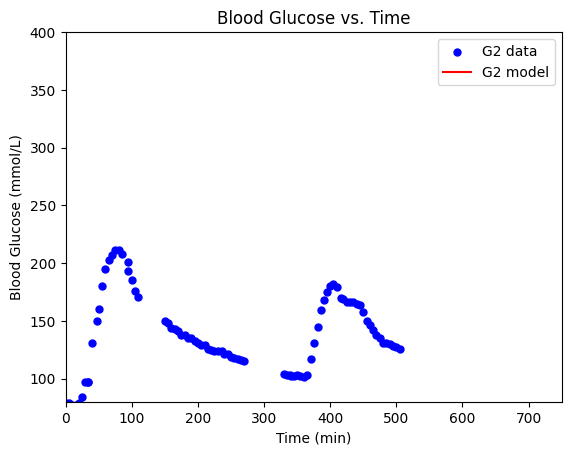

In [24]:
# Define the time range
t_values = np.linspace(0, 700, num=160)  # You can adjust the number of time points

# Define the parameter values
paras = {
    'alpha': 0.00692843,
    'beta1': 0.00141345,
    'beta2': 0.00134809,
    'I_basal': 7.56120948,
    'gamma': 7.48998466,
    'delta': 0.57186303,
    'I_max': 5.00000000
}

# Call the g function to compute the solution
solution = g1(t_values, y0, paras)

# Print or process the computed solution
print(solution)

#plot the solution
plt.figure()
plt.scatter(time_values_cop, BG_values_cop, marker='o', color='b', label='G2 data', s=25)
plt.plot(t_values, solution[:,1], color = 'r', label='G2 model')

plt.xlabel('Time (min)')
plt.ylabel('Blood Glucose (mmol/L)')
plt.title('Blood Glucose vs. Time')

plt.legend(loc='best')

#Zoom out the plot
plt.xlim(0, 750)
plt.ylim(80, 400)

#save the plot
plt.savefig('G2.png')

plt.show()


